# Predict BTC price direction - Random Forest Classifier

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os
import requests
import datetime

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
# Read in annual coin metrics from csv
metrics_2021 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_1.csv', parse_dates=True)
metrics_2020 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_2.csv', parse_dates=True)
metrics_2019 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_3.csv', parse_dates=True)
metrics_2018 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_4.csv', parse_dates=True)
metrics_2017 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_5.csv', parse_dates=True)
metrics_2016 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_6.csv', parse_dates=True)
metrics_2015 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_7.csv', parse_dates=True)
metrics_2014 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_8.csv', parse_dates=True)
metrics_2013 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_9.csv', parse_dates=True)
metrics_2012 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_10.csv', parse_dates=True)
metrics_2011 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_11.csv', parse_dates=True)
metrics_2010 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_12.csv', parse_dates=True)
metrics_2009 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_13.csv', parse_dates=True)

In [3]:
# Read in combined BTC Google trends data
btc_google_trends = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_google_trends/btc_trends_combined.csv', parse_dates=True)
btc_google_trends.reset_index(inplace=True)
btc_google_trends.rename(columns={'date':'time', 'bitcoin':'BTC_Trends'},inplace=True)
btc_google_trends = btc_google_trends.drop(columns='index')
btc_google_trends['time'] = pd.to_datetime(btc_google_trends['time']).dt.date
btc_google_trends = btc_google_trends.set_index('time')
btc_google_trends.tail()

,BTC_Trends
time,
2021-11-28,35
2021-12-05,38
2021-12-12,33
2021-12-19,31
2021-12-26,29


In [4]:
# Concat all csv files  and print combined csv
combined = pd.concat([metrics_2009,metrics_2010,metrics_2011,metrics_2012,metrics_2013,metrics_2014,metrics_2015,metrics_2016,metrics_2017,metrics_2018,metrics_2019,metrics_2020,metrics_2021], axis=0)
combined_df = pd.DataFrame(combined)
combined_df = combined_df.drop_duplicates(keep='first')
combined_df.tail()

,time,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr
346,2021-12-13 00:00:00+00:00,btc,996713,1.915300,8.842453e+11,1.695883e+08,69.789128,46785.327841,1.890006e+07,281785,1.267024e+10,14.525969
347,2021-12-14 00:00:00+00:00,btc,966596,1.974878,9.127791e+11,1.780076e+08,72.469440,48292.682250,1.890098e+07,281921,1.259537e+10,14.533207
348,2021-12-15 00:00:00+00:00,btc,1058257,1.995927,9.229897e+11,1.695883e+08,62.867727,48830.622386,1.890186e+07,280841,1.468146e+10,14.536127
349,2021-12-16 00:00:00+00:00,btc,873836,1.948720,9.009626e+11,1.383167e+08,56.242508,47663.469108,1.890258e+07,256019,1.601925e+10,14.533316
350,2021-12-17 00:00:00+00:00,btc,979005,1.896527,8.758845e+11,1.792104e+08,48.186258,46334.483749,1.890351e+07,260119,1.817706e+10,14.538415


In [5]:
combined_df.isnull().sum()

time                0
asset               0
AdrActCnt           0
CapMVRVCur        561
CapMrktCurUSD     561
HashRate            6
NVTAdj            260
PriceUSD          561
SplyCur             0
TxCnt               0
TxTfrValAdjUSD    561
VelCur1yr           6
dtype: int64

In [6]:
combined_df.dropna(inplace=True)
combined_df.isnull().sum()

time              0
asset             0
AdrActCnt         0
CapMVRVCur        0
CapMrktCurUSD     0
HashRate          0
NVTAdj            0
PriceUSD          0
SplyCur           0
TxCnt             0
TxTfrValAdjUSD    0
VelCur1yr         0
dtype: int64

In [7]:
# Remove timestamp in time column
combined_df['time'] = pd.to_datetime(combined_df['time']).dt.date
combined_df = combined_df.set_index('time')
combined.to_csv('resources/btc_annual_metrics/combined.csv')

In [8]:
# Concat metrics and google trends data
combined_df = pd.concat([combined_df,btc_google_trends],axis=1).dropna()
combined_df = combined_df.reset_index()
combined_df = combined_df.rename(columns={'index':'time'})
combined_df = combined_df.set_index('time')
combined_df.tail()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr,BTC_Trends
time,,,,,,,,,,,,
2021-11-14,btc,806451.0,2.684880,1.227371e+12,1.753464e+08,152.556436,65032.225655,1.887328e+07,222847.0,8.045358e+09,13.858569,35.0
2021-11-21,btc,842004.0,2.424880,1.114511e+12,1.487822e+08,145.286759,59032.624102,1.887958e+07,218828.0,7.671111e+09,13.996473,34.0
2021-11-28,btc,816560.0,2.336712,1.081177e+12,1.551410e+08,105.588433,57248.569696,1.888566e+07,215317.0,1.023954e+10,14.212248,35.0
2021-12-05,btc,978899.0,2.016818,9.319010e+11,1.843117e+08,56.706958,49327.093600,1.889228e+07,221615.0,1.643363e+10,14.424520,38.0
2021-12-12,btc,725043.0,2.049751,9.475399e+11,1.683856e+08,187.570249,50136.572257,1.889918e+07,211066.0,5.051653e+09,14.518037,33.0


In [78]:
# Read in Relative Strength(RSI) data
rsi_btc = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/rsi_btc.csv', parse_dates=True, index_col='time')
rsi_btc.tail()

,RSI_14
time,
2021-08-09,74.081184
2021-08-10,70.488415
2021-08-11,70.855868
2021-08-12,64.954881
2021-08-13,71.595086


In [77]:
# Read in Rate of Change (ROC) data
roc_btc = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/roc_btc.csv', parse_dates=True, index_col='time')
roc_btc.tail()

,ROC_14
time,
2021-08-09,23.556980
2021-08-10,16.260704
2021-08-11,14.364667
2021-08-12,10.775748
2021-08-13,14.184890


In [74]:
# Read in Money Flow Index (MFI) data
mfi_btc = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/mfi_btc.csv', parse_dates=True)
mfi_btc = mfi_btc.rename(columns={'Date':'time'})
mfi_btc['time'] = pd.to_datetime(mfi_btc['time']).dt.date
mfi_btc = mfi_btc.set_index('time').dropna()
mfi_btc.tail()

,MFI_14
time,
2021-08-02,81.204203
2021-08-03,79.522234
2021-08-04,79.662530
2021-08-05,80.643163
2021-08-06,79.699408


In [75]:
# Read in True Strength (TSI) data
tsi_btc = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/tsi_btc.csv', parse_dates=True)
tsi_btc = tsi_btc.rename(columns={'Date':'time'})
tsi_btc['time'] = pd.to_datetime(tsi_btc['time']).dt.date
tsi_btc = tsi_btc.set_index('time').dropna()
tsi_btc.tail()

,TSI_13_25_13,TSIs_13_25_13
time,,
2021-08-09,35.378104,23.658239
2021-08-10,36.440256,25.484241
2021-08-11,37.390356,27.185115
2021-08-12,36.345006,28.493671
2021-08-13,37.652326,29.802050


In [81]:
# Create model features dataframe
features_btc = pd.concat([combined_df,rsi_btc, roc_btc, mfi_btc,tsi_btc], axis=1).dropna()
features_btc.tail()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr,BTC_Trends,RSI_14,ROC_14,MFI_14,TSI_13_25_13,TSIs_13_25_13
time,,,,,,,,,,,,,,,,,
2021-07-04,btc,843475.0,1.826545,6.628419e+11,8.210884e+07,137.763443,35355.607888,1.874786e+07,169312.0,4.811450e+09,11.563401,31.0,49.361525,-0.686333,44.991876,-9.692990,-13.373138
2021-07-11,btc,690684.0,1.771750,6.424764e+11,8.924874e+07,162.083349,34258.441390,1.875381e+07,160653.0,3.963864e+09,11.520694,30.0,47.788550,-0.718850,53.544626,-8.881877,-10.788879
2021-07-18,btc,651828.0,1.639258,5.948379e+11,9.787224e+07,123.714333,31707.703853,1.876004e+07,163158.0,4.808157e+09,11.461719,34.0,40.204240,-10.317752,35.959576,-14.906440,-11.976212
2021-07-25,btc,641796.0,1.818485,6.590781e+11,1.039893e+08,182.010426,35119.937436,1.876649e+07,172110.0,3.621101e+09,11.392908,39.0,57.726783,2.514697,44.052335,-5.844606,-12.318428
2021-08-01,btc,695892.0,2.006838,7.503559e+11,1.109758e+08,88.007444,39968.968954,1.877346e+07,190234.0,8.526051e+09,11.373743,33.0,64.812531,26.054441,83.305270,27.518611,8.397551


In [82]:
features_btc.to_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/features_btc.csv')

<AxesSubplot:title={'center':'EMA BTC'}, xlabel='time', ylabel='BTC Price ($)'>

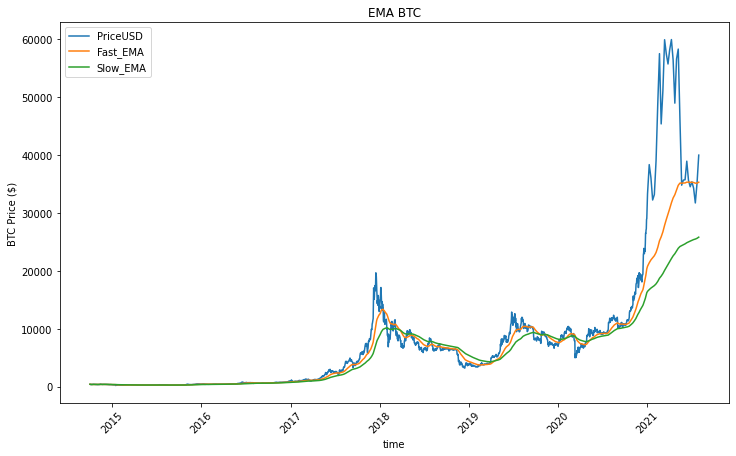

In [83]:
# Set short and long windows for EMA (Exponential Moving Average) to create trading signals features
short_window = 20
long_window = 50

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
features_btc['Fast_EMA'] = features_btc['PriceUSD'].ewm(halflife=short_window).mean()
features_btc['Slow_EMA'] = features_btc['PriceUSD'].ewm(halflife=long_window).mean()

# Plot the EMA of ETH closing prices
features_btc[['PriceUSD', 'Fast_EMA', 'Slow_EMA']].plot(figsize=(12,7), title='EMA BTC', ylabel='BTC Price ($)', rot=45) 

In [84]:
# Construct a crossover trading signal
features_btc['Crossover_Long'] = np.where(features_btc['Fast_EMA'] > features_btc['Slow_EMA'], 1.0, 0.0)
features_btc['Crossover_Short'] = np.where(features_btc['Fast_EMA'] < features_btc['Slow_EMA'],-1.0, 0.0)
features_btc['Crossover_Signal'] = features_btc['Crossover_Long'] + features_btc['Crossover_Short']

In [85]:
# Calculate daily return
features_btc['Daily_Return'] = features_btc['PriceUSD'].pct_change()

In [86]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
features_btc['Positive_Return'] = np.where(features_btc['Daily_Return'] > 0, 1.0, 0.0)

features_btc = features_btc.dropna()

# Convert date to str to set test and train windows 
features_btc.index = pd.to_datetime(features_btc.index, format = '%Y/%m/%d')
features_btc.tail()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,...,MFI_14,TSI_13_25_13,TSIs_13_25_13,Fast_EMA,Slow_EMA,Crossover_Long,Crossover_Short,Crossover_Signal,Daily_Return,Positive_Return
time,,,,,,,,,,,,,,,,,,,,,
2021-07-04,btc,843475.0,1.826545,6.628419e+11,8.210884e+07,137.763443,35355.607888,1.874786e+07,169312.0,4.811450e+09,...,44.991876,-9.692990,-13.373138,35280.974089,25257.676446,1.0,0.0,1.0,0.024607,1.0
2021-07-11,btc,690684.0,1.771750,6.424764e+11,8.924874e+07,162.083349,34258.441390,1.875381e+07,160653.0,3.963864e+09,...,53.544626,-8.881877,-10.788879,35246.142871,25381.592636,1.0,0.0,1.0,-0.031032,0.0
2021-07-18,btc,651828.0,1.639258,5.948379e+11,9.787224e+07,123.714333,31707.703853,1.876004e+07,163158.0,4.808157e+09,...,35.959576,-14.906440,-11.976212,35125.610648,25468.686079,1.0,0.0,1.0,-0.074456,0.0
2021-07-25,btc,641796.0,1.818485,6.590781e+11,1.039893e+08,182.010426,35119.937436,1.876649e+07,172110.0,3.621101e+09,...,44.052335,-5.844606,-12.318428,35125.417398,25601.557708,1.0,0.0,1.0,0.107615,1.0
2021-08-01,btc,695892.0,2.006838,7.503559e+11,1.109758e+08,88.007444,39968.968954,1.877346e+07,190234.0,8.526051e+09,...,83.305270,27.518611,8.397551,35290.406545,25799.358105,1.0,0.0,1.0,0.138071,1.0


In [89]:
# Select model features and timeframe for train data
X = features_btc[['AdrActCnt','CapMrktCurUSD','CapMVRVCur','HashRate','NVTAdj','TxCnt','TxTfrValAdjUSD','VelCur1yr','Crossover_Signal','BTC_Trends','RSI_14','ROC_14','MFI_14','TSI_13_25_13','TSIs_13_25_13']]
X_train = X[:'2020']

In [90]:
# Select prediction variable and timeframe for train data
y = features_btc['Positive_Return']
y_train = y[:'2020']

In [91]:
# Define timeframe for testing data
X_test = X['2021':]
y_test = y['2021':]

In [94]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [95]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [97]:
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Perform the grid search for the optimal set of tree parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

n_estimators = [20,500]
max_depth= [5,10]
num_folds = 10
scoring = 'accuracy'

criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, \
  criterion = criterion )

model = RandomForestClassifier(n_jobs=-1)

kfold = KFold(n_splits=num_folds, random_state=None)
grid = GridSearchCV(estimator=model, param_grid=param_grid, \
  scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_,\
  grid_result.best_params_))

Best: 0.688839 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 500}


In [111]:
# Define the model using optimized settings (also use if you want to run without optimizer above)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier(n_jobs=-1)
model = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=500, n_jobs=-1)

In [112]:
# Fit the model
model = model.fit(X_train_scaled, y_train)

In [113]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [114]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [115]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,5,8
Actual 1,0,18


Accuracy Score : 0.7419354838709677
Classification Report
              precision    recall  f1-score   support

         0.0       1.00      0.38      0.56        13
         1.0       0.69      1.00      0.82        18

    accuracy                           0.74        31
   macro avg       0.85      0.69      0.69        31
weighted avg       0.82      0.74      0.71        31



In [116]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results[-20:]

,Positive_Return,Predicted Value
time,,
2021-03-21,0.0,1.0
2021-03-28,0.0,1.0
2021-04-04,1.0,1.0
2021-04-11,1.0,1.0
2021-04-18,0.0,0.0
2021-04-25,0.0,0.0
2021-05-02,1.0,1.0
2021-05-09,1.0,1.0
2021-05-16,0.0,0.0


In [117]:
# List the features sorted in descending order by feature importance
importances = model.feature_importances_
sorted(zip(model.feature_importances_, X.columns), reverse=True)

[(0.1825527622835474, 'RSI_14'),
 (0.0997001597340209, 'TSI_13_25_13'),
 (0.08055366379341732, 'ROC_14'),
 (0.07612387671099759, 'MFI_14'),
 (0.06906542683082018, 'TSIs_13_25_13'),
 (0.06216598200868968, 'NVTAdj'),
 (0.05848655245379152, 'CapMVRVCur'),
 (0.05838548161613846, 'TxCnt'),
 (0.05671710271124466, 'AdrActCnt'),
 (0.05370313028301578, 'TxTfrValAdjUSD'),
 (0.051965899856178686, 'VelCur1yr'),
 (0.05066990995919652, 'HashRate'),
 (0.04930872944312223, 'CapMrktCurUSD'),
 (0.04761503821014977, 'BTC_Trends'),
 (0.002986284105669363, 'Crossover_Signal')]

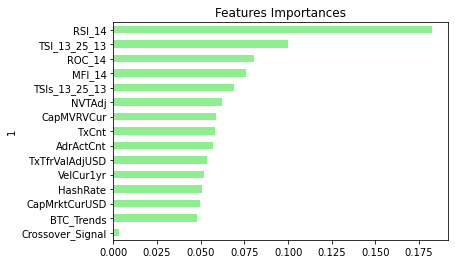

In [118]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_,    X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)

importances_sorted = importances_df.sort_values(by=
'Feature Importances')

importances_plot = importances_sorted.plot(kind='barh', color='lightgreen', title='Features Importances', legend=False)

In [ ]:
# RSI is the most dominant feature which shows that BTC price is primarily determined by momentum.